In [ ]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import lasio
import os
import pandas as pd
path_to_RIGIS = r'./welldata/RIGIS/'
path_to_GIS = r'./welldata/GIS_md/'
path_to_welltracks = r'./welldata/welltracks.txt'
lasFileNames = []

def getLasDataFrames(path = path_to_RIGIS):
    lasDF = []
    for file in os.listdir(path):
        if file.endswith('.las'):
            lasFileNames.append(file[:-4])
            lasDF.append(lasio.read(path+file).df())
    return lasDF

lasDataFrame = getLasDataFrames()

In [ ]:
len(lasDataFrame)

In [ ]:
def parse_welltracks():
    welltracks = []
    f = open(path_to_welltracks)
    welldata = f.read().split(';')
    for well in welldata:
        if len(well.split()) > 2:
            name = well.split()[2][:-1]
            data = well.split()[3:]
            x = [float(data[i]) for i in range(len(data)) if i % 4 == 0]
            y = [float(data[i]) for i in range(len(data)) if i % 4 == 1]
            tvdss = [float(data[i]) for i in range(len(data)) if i % 4 == 2]
            md = [float(data[i]) for i in range(len(data)) if i % 4 == 3]
            if(lasFileNames.count(name) > 0):
                welltracks.append([name, x, y ,tvdss, md]) # в таком виде хранятся
            else:
                print(name)

    return welltracks


In [ ]:
from scipy.interpolate import interp1d
import math
def get_heights_list():
    welltracks = parse_welltracks()
    tvdconv = []
    for tracknum in range(len(welltracks)):
        f = interp1d(welltracks[tracknum][4], welltracks[tracknum][3])
        tvdconv.append(f)

    heights = []
    print(len(lasDataFrame))
    for k  in range(len(lasDataFrame)):
        frame = lasDataFrame[k]
        tmp_sum = 0
        for i in range(len(frame['KG_T']) - 1):
            if (frame['KG_T'].array[i + 1] >= 0):
                tmp_sum += tvdconv[k](frame['KG_T'].index[i + 1]) - tvdconv[k](frame['KG_T'].index[i])
        heights.append(tmp_sum)
    return heights
get_heights_list()

In [ ]:
def get_k_nas_por():
    k_nas = []
    k_por = []
    for k in range(len(lasDataFrame)):
        frame = lasDataFrame[k]
        k_nas.append([val for val in frame['KG_T']])
        for k_w in range(len(k_nas)):
            for k in range(len(k_nas[k_w])-1,-1,-1):
                if math.isnan(k_nas[k_w][k]):
                    k_nas[k_w].pop(k)
        k_por.append([val for val in frame['KP_T']])

        for k_w in range(len(k_por)):
            for k in range(len(k_por[k_w])-1,-1,-1):
                if math.isnan(k_por[k_w][k]):
                    k_por[k_w].pop(k)
    return (k_nas, k_por)
k_nas,k_por = get_k_nas_por()

In [ ]:
def dist(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2+(y1-y2)**2)
    
def perimeter(boundary):
    (prev_x,prev_y) = boundary[-1]
    perim = 0
    for (x,y) in boundary:
        perim += dist(x,y,prev_x,prev_y)
        prev_x, prev_y = x,y
    return perim
def getCommonLength(boundary1, boundary2):
    first_pt = -1
    second_pt = -1
    for i in range(int(boundary1.size/2 - 1)):
        for j in range(int(boundary2.size/2 - 1)):
            (x1, y1) = boundary1[i]
            (x2, y2) = boundary2[j]
            if(x1 == x2 and y1 == y2):
                if first_pt == -1:
                    first_pt = (x1,y1)
                else:
                    second_pt = (x2, y2)
                    return dist(first_pt[0],first_pt[1],second_pt[0],second_pt[1])
    return 0
    


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from shapely import geometry
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

welltracks = parse_welltracks()
print('len(welltrack) = ', len(welltracks))
boundary = np.load("boundary.npy",'r') 

c = np.array([(track[1][0], track[2][0]) for track in welltracks])
s = geometry.Polygon(boundary)
main_area = s.area
region_polys, region_pts = voronoi_regions_from_coords(c, s)
perimeters = []
boundaries = []
new_polys = []
print('len(region_polys) = ', len(region_polys))
for i in range(len(region_polys)):
    #print(type(region_polys[i]))
    try:
        new_polys.append(region_polys[i])
        perimeters.append(perimeter(np.array(region_polys[i].boundary)))
        boundaries.append(region_polys[i].boundary)
    except Exception as e:
        perimeters.append(perimeter(np.array(list(region_polys[i])[0].boundary)))
        boundaries.append(list(region_polys[i])[0].boundary)


In [ ]:
len(boundaries)

In [ ]:

#print(perimeters)
fig, ax = subplot_for_map(figsize=(15, 9), dpi=400)
print("len(welltracks) = ", len(welltracks))
for i in range(len(welltracks)):
    ax.annotate(str(i), (welltracks[i][1][0], welltracks[i][2][0]), fontsize=7)
plot_voronoi_polys_with_points_in_area(ax, s, region_polys, c, region_pts)
plt.show()


In [ ]:
mat_size = len(welltracks)
print('mat size is ', mat_size)
adj_mat = [np.array([-1 for i in range(mat_size)]) for j in range(mat_size)]
for i in range(mat_size - 1):
    for j in range(mat_size - 1):
        for reg1 in region_pts[i]:
            for reg2 in region_pts[j]:
                if (i == j):
                    adj_mat[reg1][reg2] = 0
                    continue
                adj_mat[reg1][reg2] = getCommonLength(np.array(boundaries[i]), np.array(boundaries[j]))
                if(adj_mat[reg1][reg2] > 0):
                    print(reg1, ' and ', reg2, ' are neibors with common length ', adj_mat[reg1][reg2])
print(adj_mat)

In [ ]:
squares = []
from main import parse_welltracks
for i in range(len(region_polys)):
    squares.append(region_polys[i].area)

In [ ]:
def get_dis_mat():
    dis_mat = [[0 for i in range(len(welltracks))] for i in range(len(welltracks))]
    for well1 in range(len(welltracks)):
        for well2 in range(len(welltracks)):
            x1 = welltracks[well1][1][0]
            y1 = welltracks[well1][2][0]
            x2 = welltracks[well2][1][0]
            y2 = welltracks[well2][2][0]
            dis_mat[well1][well2] = dist(x1, y1, x2, y2) / 2
    return dis_mat
dis_mat = get_dis_mat()

In [ ]:
bg = 0.00848016
def zero_formula(S, H, kp, kg, bg = 0.00848016, ft = 1, fp = 1):
    return S*H*kp*kg/bg


In [ ]:
mean_k_nas = [sum(k)/len(k) for k in k_nas if len(k) > 0]
mean_k_por = [sum(k)/len(k) for k in k_por if len(k) > 0]
heights = get_heights_list()

In [ ]:
from vis_rigis_data import visualize_data
print("zero_formula = ", zero_formula(main_area, sum(heights)/len(heights), sum(mean_k_por)/len(mean_k_por), sum(mean_k_nas)/len(mean_k_nas)))
visualize_data(heights, 6)
print("k_por med = ", mean_k_por[0])
print("k_nas med = ", mean_k_nas[0])
#plt.plot(,[])

In [ ]:
len([np.mean(x) for x in k_nas])

In [ ]:
for i in range(len(dis_mat)):
    for j in range(len(dis_mat[i])):
        if(adj_mat[i][j] == 0):
            dis_mat[i][j] = 0

In [ ]:
from get_value import get_value

print(len(mean_k_nas), len(mean_k_por), len(heights), len(squares), len(adj_mat), len(perimeters))

#v1 = get_value(mean_k_nas, mean_k_por, heights, squares, adj_mat, perimeters)
#sum(v1)/bg

In [ ]:
import copy
def get_value(k_gas,k_por,h,S,mat,P):
    value = []
    temp_value = []
    for i in range(len(k_gas)):
        temp_value.append(k_gas[i]*k_por[i]*h[i]/2)
        value.append(k_gas[i]*k_por[i]*h[i]/2)
    for i in range(len(k_gas)):
        for V in range(len(mat[i])):
            if mat[i][V]>0:
                value[i]+=mat[i][V]/P[i]*temp_value[V]
    value=[S[i]*x for x in value]
    return value


# In[181]:


def get_value2(k_gas,k_por,h,S,mat,P,compress = 1000000):
    '''Считаем произведение вероятностей. Каждое значение перемножается с каждым другим. Перемножаем k_por k_gas h'''
    gas_por = []
    for i in range (len(k_gas)):
        if sum(k_gas[i])!=0:
            temp = []
            for gas in k_gas[i]:
                for por in k_por[i]:
                    temp.append(gas*por)

            gas_por_h = []
            for gaspor in temp:
                for H in h[i]:
                    gas_por_h.append(gaspor*H/2)

            gas_por.append(gas_por_h)
        else:
            gas_por.append([0])
    print([len(gas) for gas in gas_por])
    adskoe_raspredelenie=[]
    for id_well in range (len(k_gas)):
        print(id_well,'/', len(k_gas))
        save = copy.deepcopy(gas_por[id_well])
        for id_p_j in range(len(mat[id_well])):
                temp = []
                if len(save)>compress:
                    #print(len(save),len(gas_por[id_p_j]),len(honey_compress(temp)))
                    save=honey_compress(save)
                if (id_p_j!= id_well and mat[id_well][id_p_j]>0):
                    for V in save:
                        for V_j in gas_por[id_p_j]:
                            temp.append(V+V_j*mat[id_well][id_p_j]/P[id_well])
                    save = copy.deepcopy(temp)
                #else:
        save = [x*S[id_well] for x in save]
        
        adskoe_raspredelenie.append(save)
    return adskoe_raspredelenie


def get_value3(k_gas,k_por,h,S,mat,dis_mat,P,compress = 1000000):
    '''Считаем произведение вероятностей. Каждое значение перемножается с каждым другим. Перемножаем k_por k_gas h'''
    gas_por = []
    for i in range (len(k_gas)):
        if sum(k_gas[i])!=0:
            temp = []
            for gas in k_gas[i]:
                for por in k_por[i]:
                    temp.append(gas*por)

            gas_por_h = []
            for gaspor in temp:
                for H in h[i]:
                    gas_por_h.append(gaspor*H/2)

            gas_por.append(gas_por_h)
        else:
            gas_por.append([0])
    print([len(gas) for gas in gas_por])
    adskoe_raspredelenie=[]
    for id_well in range (len(k_gas)):
        printProgressBar(id_well, len(k_gas))
        #print(f'{id_well+1}/{len(k_gas)} is {int((id_well+1)/len(k_gas)*100)}',"%")
        save = copy.deepcopy(gas_por[id_well])
        for id_p_j in range(len(mat[id_well])):
                temp = []
                if len(save)>compress:
                    save=honey_compress(save)
                if (id_p_j!= id_well and mat[id_well][id_p_j]>0):
                    nu_norm = sum([x/y for (x,y) in zip(mat[id_well],dis_mat[id_well]) if y != 0])
                    if(nu_norm == 0):
                        nu_norm = 1
                    for V in save:
                        for V_j in gas_por[id_p_j]:
                            
                            temp.append(V+V_j*mat[id_well][id_p_j]/dis_mat[id_well][id_p_j]/nu_norm)
                    save = copy.deepcopy(temp)
        summat = sum(mat[id_well])
        summatdis = sum(dis_mat[id_well])
        coeff =(2*P[id_well]*summatdis)/ \
        (P[id_well]*summatdis+sum([x*y for x,y in zip(mat[id_well],dis_mat[id_well])]))
        save = [x*S[id_well] for x in save]
        #save = [x*coeff for x in save]
        adskoe_raspredelenie.append(save)
    return adskoe_raspredelenie

def honey_compress(value_list, razmer_zhim=1000):
    value= len(value_list)
    temp_div= 2
    min_div = 1
    while(value>razmer_zhim):
        if (value%temp_div==0):
            min_div*=temp_div
            value= value//temp_div
        else:
            temp_div+=1
    value_list.sort()
    new_value_list=[sum(value_list[(x)*min_div:(x+1)*min_div])/min_div for x in range(value)]
    return new_value_list


In [35]:
v3 =get_value3(k_nas, k_por, [[h] for h in heights], squares, adj_mat,dis_mat, perimeters, 10000)

In [38]:
from collections import Counter
def itog_rasp(all_value,honey = 50000):
    first_well = all_value[0]
    for id_value in range(1,len(all_value)):
        temp = []
        if len(first_well)>honey:
            first_well=honey_compress(first_well)
        if len(all_value[id_value])>honey:
            all_value[id_value]=honey_compress(all_value[id_value])
        printProgressBar(id_value+1, len(all_value))
        for first in first_well:
            for second in all_value[id_value]:
                temp.append(first+second)
        first_well= copy.deepcopy(temp)
        
    return first_well

In [52]:
v_itog = [i/bg for i in itog_rasp(v3)]
len(v_itog)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


98923

In [229]:
from turtle import color
from vis_rigis_data import expection, dispersion, normal_

def visualize_data(data = [], _div = 5, x_label = 'x_label', y_label = 'y_label', dpi_ = 100):
    data_count = [0 for x in range(_div)]
    print("len data = ", len(data))
    max_data = max(data) + 0.01
    min_data = min(data)
    delta = max_data - min_data

    step = delta / _div
    print("step =",step)
    steps = [min_data + step / 2]
    for i in range(1,_div):
        steps.append(steps[-1] + step)
    for k in data:
        index = math.floor((k - min_data) / step)
        if index >= len(data_count):
            index -= 1
        data_count[math.floor(index)] += 1
    print(data_count)

    fig, ax = plt.subplots(layout='constrained', dpi = dpi_)
    fig.suptitle('_div = '+str(_div))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    fig.tight_layout()
    x = steps
    integr = sum([step * i for i in data_count])
    print("integr = ", integr)
    norm_data = [i / integr for i in data_count]
    #ax.plot(steps, norm_data)
    y = [1 - sum([step*k for k in norm_data[:i+1]]) for i in range(len(data_count))]
    print("y = ", y)
    f = interp1d(steps, y)
    lenx = 200
    x_linspace = np.linspace(min(steps), max(steps), lenx)
    k = lenx // 2
    find_values = [0.9, 0.5, 0.1]
    for find_value in find_values:
        l = 0 
        r = lenx # [0, lenx)
        found = x[k]
        while l != r - 1:
            if(f(found) >= find_value):
                l = k
            else:
                r = k
            k = (r+l)//2
            found = x[k]
            if l == r - 1:
                break
                return found
        ax.vlines(found, 0, f(found), colors='r')
        ax.plot([min_data, found], [f(found)]*2, color='r')
        ax.scatter(found, f(found), color='r')
        ax.annotate('P' + str(int(find_value*100))+' = ' + str(int(found))+' мет. куб', (found, find_value), fontsize = 14)
    ax.plot(x_linspace, f(x_linspace))
    e = expection(data)
    print('e = ', e)
    d = dispersion(data, e)
    print('d = ', d)
    #ax.plot(x, normal_(x, e, d), label = 'Нормальное распределение')
    print("integral = ", sum(step * normal_(x,e,d)))
    from matplotlib.ticker import FormatStrFormatter
    #ax.ticklabel_format(useOffset=False, style='sci', scilimits = (0, 6), axis='x')
    plt.ylim(bottom = 0)
    plt.xlim(left=min(steps))
    plt.ticklabel_format(useOffset=True, style='sci', scilimits = (6, 6), axis='x')
    plt.show()

len data =  98923
step = 1934541628.748647
[154, 150, 293, 496, 802, 1246, 1842, 2608, 3523, 4547, 5601, 6596, 7432, 8017, 8258, 8169, 7718, 6995, 6059, 5032, 3997, 3045, 2214, 1540, 1030, 660, 416, 242, 135, 106]
integr =  191370661540702.38
y =  [0.9984432336261537, 0.9969269027425371, 0.9939650030832061, 0.9889510022947141, 0.9808436865036443, 0.9682480312970694, 0.9496274880462582, 0.9232635484164451, 0.8876499903965711, 0.8416849468778747, 0.7850651516836327, 0.7183870282947342, 0.6432578874478129, 0.562215056154787, 0.47873598657541716, 0.3961566066536598, 0.3181363282553096, 0.24742476471599106, 0.18617510589043984, 0.1353072591813833, 0.09490209556928098, 0.06412057863186504, 0.04173953478968473, 0.02617187105122143, 0.01575973231705441, 0.00908787642914155, 0.004882585445245002, 0.0024362382863436505, 0.0010715404910887072, -2.220446049250313e-16]
e =  562040009637.3398
d =  8.38111878600991e+19
integral =  6.847655484584566


C:\Users\evgeny\AppData\Local\Temp\ipykernel_11196\3391381203.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


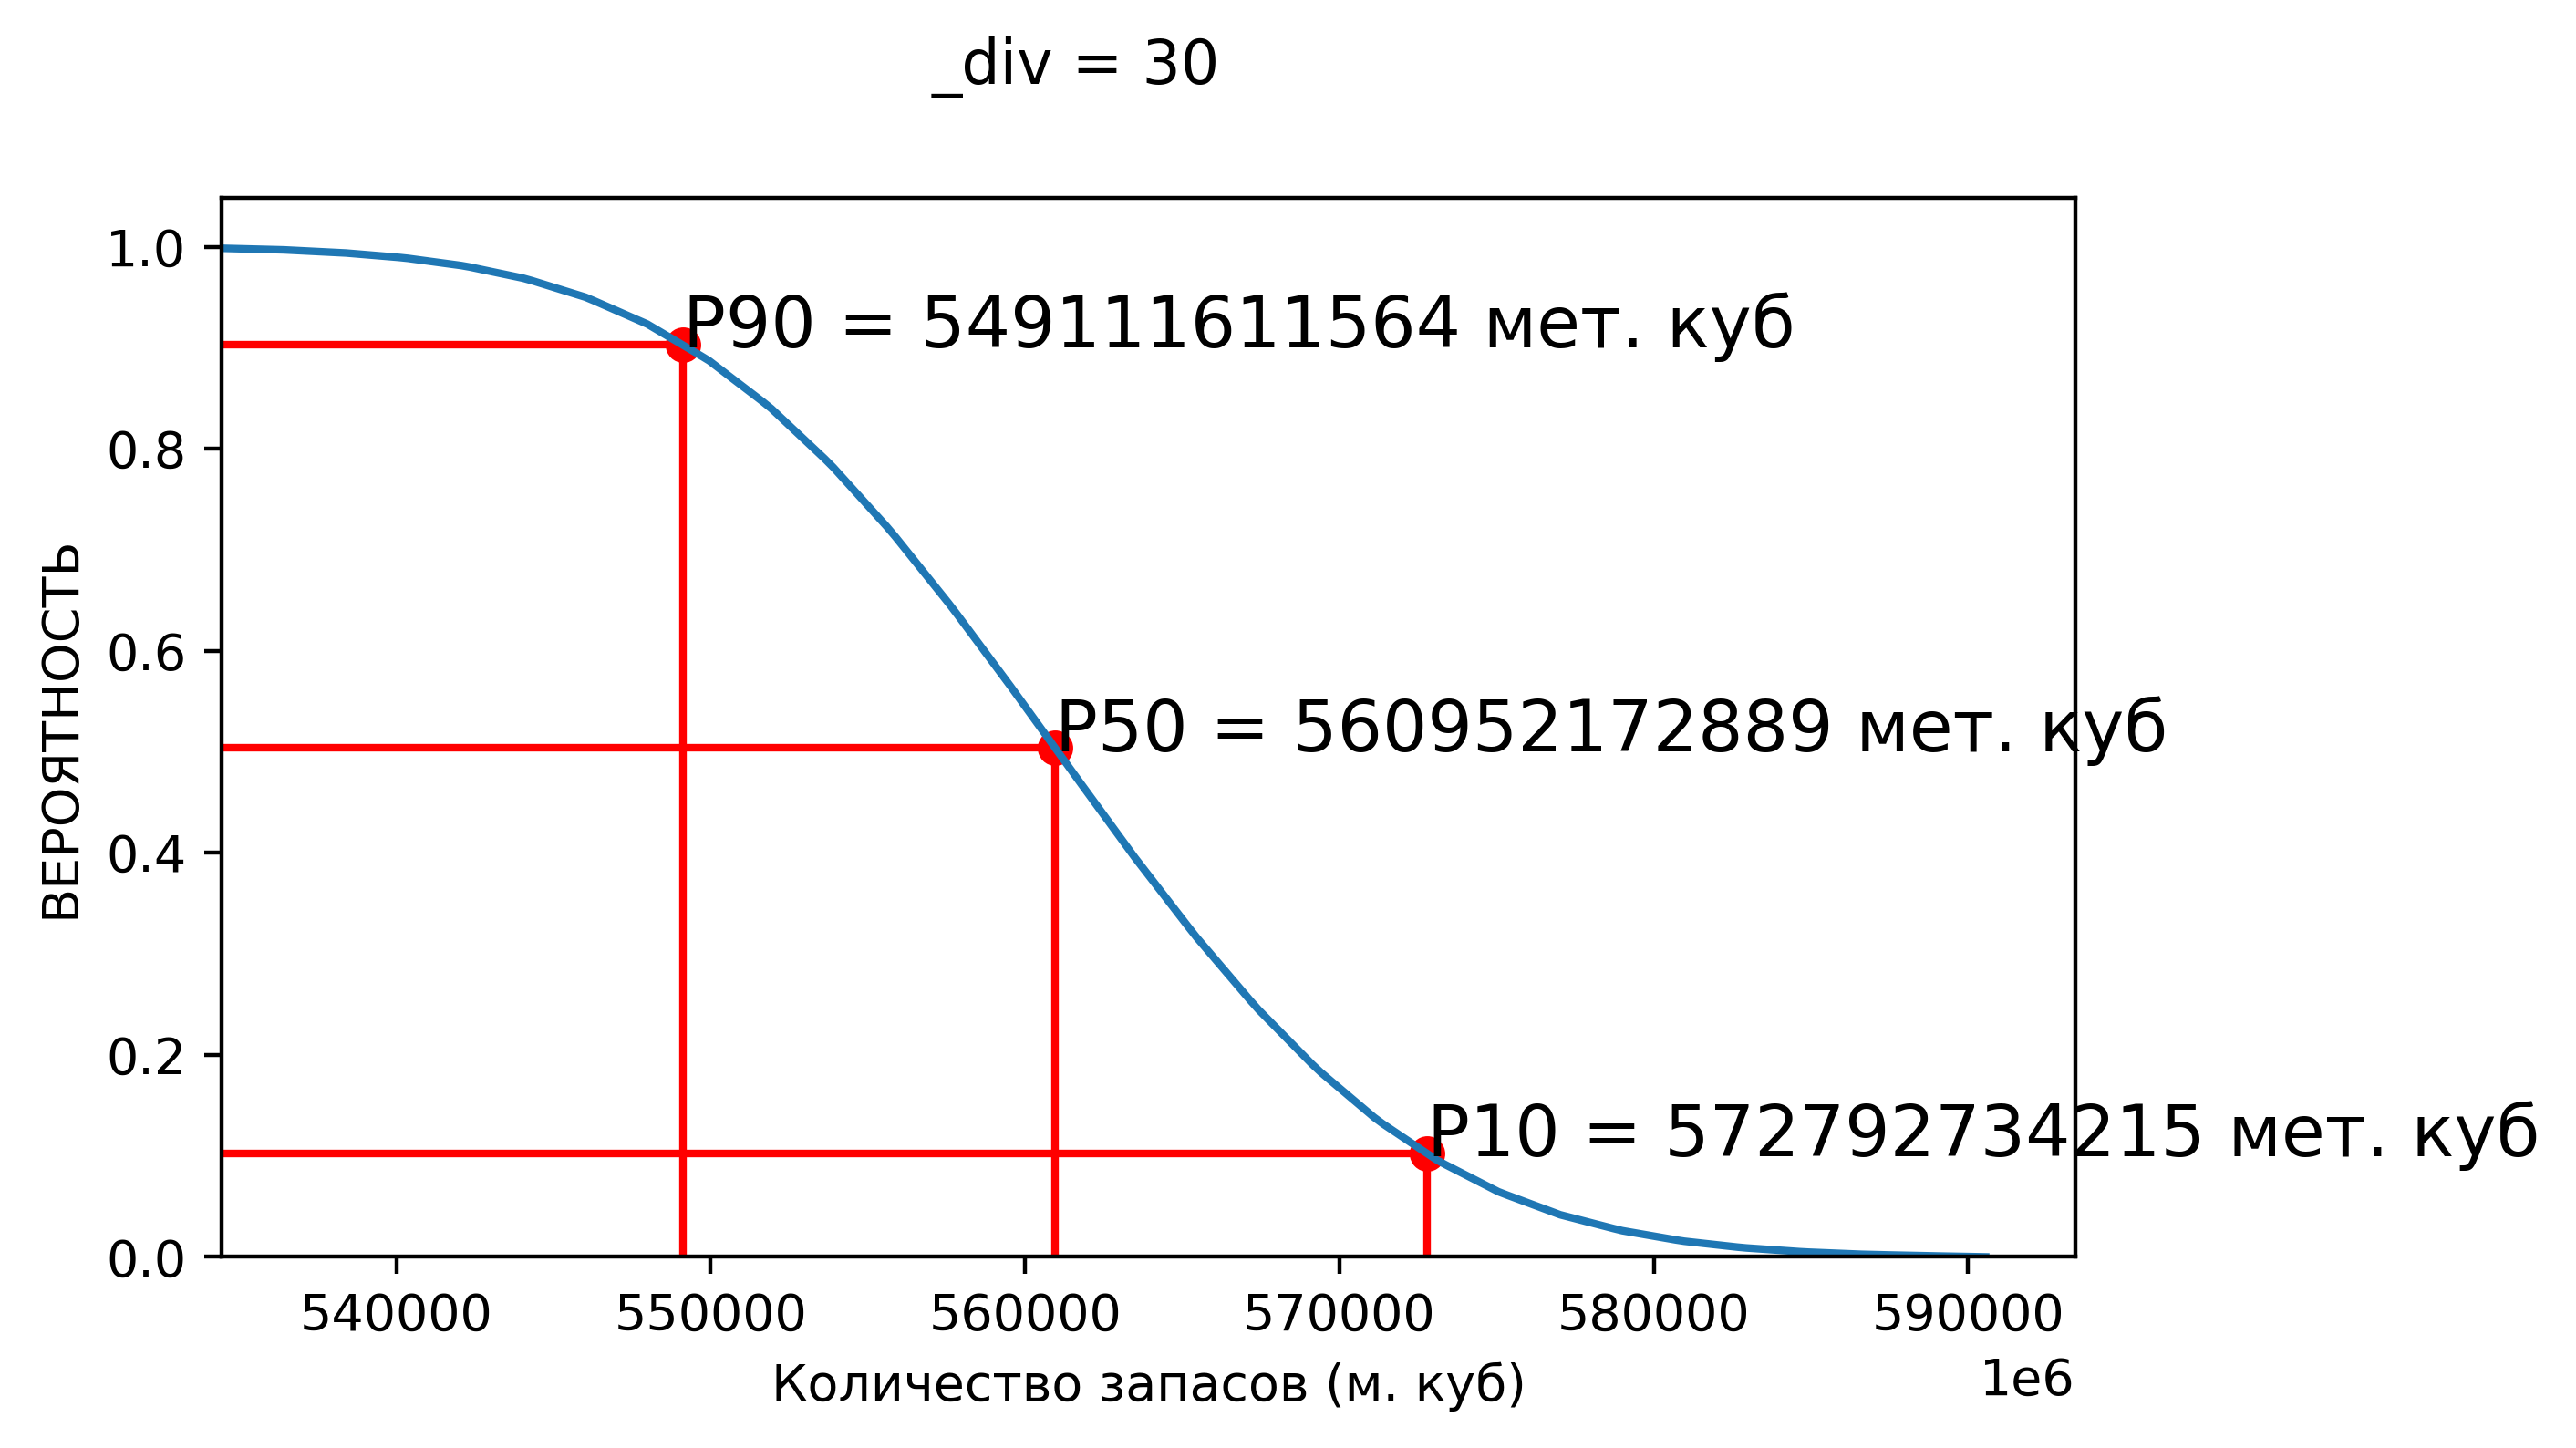

In [230]:
visualize_data(v_itog, 30, "Количество запасов (м. куб)", "ВЕРОЯТНОСТЬ", 400)

In [43]:
sum(v_itog)/len(v_itog)/bg

562040009637.3359